### CS 487/519 Applied Machine Learning I
#### Open Machine Learning Project
##### Team No: 03
##### Team Members:
1. Nishan Rai 
2. Pushparaj Dahal


##### Dataset
##### BRaTS 2021 Dataset: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
##### LIDC-IDRI Dataset: https://www.kaggle.com/datasets/zhangweiled/lidcidri?select=LIDC-IDRI-slices

##### Setup and Configuration
Here we define paths and check for GPU availablity.

In [1]:
import torch
import numpy as np
import random

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # slower but reproducible
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Relative path to the TAR file
tar_path = "Data/BraTS2021_00495.tar"


In [4]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: NVIDIA RTX A4000


##### Explore Extracted Files
We inspect the contents of the extracted BraTs dataset directory

In [5]:
import os

print("Files inside extracted folder:")
print(os.listdir("Data/BraTS2021_00495"))


Files inside extracted folder:
['BraTS2021_00495_t1ce.nii.gz', 'BraTS2021_00495_flair.nii.gz', 'BraTS2021_00495_t2.nii.gz', 'BraTS2021_00495_seg.nii.gz', 'BraTS2021_00495_t1.nii.gz']


##### Load the NIfTI Files
This step loads the MRI scans and their corresponding segmentation masks.

In [6]:
import nibabel as nib

nii_dir = "Data/BraTS2021_00495"

# Load the different MRI modalities
flair = nib.load(os.path.join(nii_dir, "BraTS2021_00495_flair.nii.gz"))     # Fluid-attenuated inversion recovery
t1 = nib.load(os.path.join(nii_dir, "BraTS2021_00495_t1.nii.gz"))           # T1-weighted
t1ce = nib.load(os.path.join(nii_dir, "BraTS2021_00495_t1ce.nii.gz"))       # T1 with contrast enhancement
t2 = nib.load(os.path.join(nii_dir, "BraTS2021_00495_t2.nii.gz"))           # T2-weighted

# Load the segmentation mask
seg = nib.load(os.path.join(nii_dir, "BraTS2021_00495_seg.nii.gz"))         # Ground truth segmentation


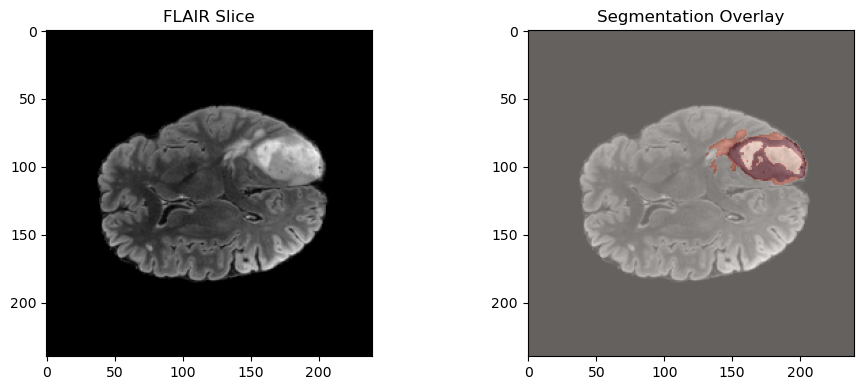

In [7]:
import matplotlib.pyplot as plt

# Assuming flair is a nibabel image object and seg is the corresponding segmentation
flair_data = flair.get_fdata()
seg_data = seg.get_fdata()

slice_idx = 80  # Example slice index

plt.figure(figsize=(10, 4))

# FLAIR image
plt.subplot(1, 2, 1)
plt.imshow(flair_data[:, :, slice_idx], cmap="gray")
plt.title("FLAIR Slice")

# Segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(flair_data[:, :, slice_idx], cmap="gray")
plt.imshow(seg_data[:, :, slice_idx], cmap="Reds", alpha=0.4)
plt.title("Segmentation Overlay")

plt.tight_layout()
plt.show()


##### Convert NIfTI to NumPy and Normalize

In [8]:
import numpy as np

# Convert NIfTI to NumPy arrays (shape: [H, W, D])
flair_np = flair.get_fdata()
t1_np = t1.get_fdata()
t1ce_np = t1ce.get_fdata()
t2_np = t2.get_fdata()
seg_np = seg.get_fdata()

# Normalize to [0, 1]
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

flair_np = normalize(flair_np)
t1_np = normalize(t1_np)
t1ce_np = normalize(t1ce_np)
t2_np = normalize(t2_np)

# Stack into [4, H, W, D]
stacked_input = np.stack([
    t1_np,
    t1ce_np,
    t2_np,
    flair_np
], axis=0)

print("Model input shape:", stacked_input.shape)


Model input shape: (4, 240, 240, 155)


##### Prepare BraTs Dataset

In [9]:
# ! pip install albumentations

##### Defie Unified Transforms

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Use this for training
train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

# Use this for validation / test
val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])


/home/grad17/nrai/miniconda3/envs/ml_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/grad17/nrai/miniconda3/envs/ml_project/lib/python3.9/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch
from torch.utils.data import Dataset

class SingleSubjectBraTSDataset(Dataset):
    def __init__(self, volume_nii, mask_nii, transform=None):
        """
        Args:
            volume_nii: nibabel Nifti1Image or numpy array with shape (4, H, W, D)
            mask_nii: nibabel Nifti1Image or numpy array with shape (H, W, D)
        """
        # FIX IS HERE:
        self.volume = volume_nii.get_fdata() if hasattr(volume_nii, 'get_fdata') else volume_nii
        self.mask = mask_nii.get_fdata() if hasattr(mask_nii, 'get_fdata') else mask_nii

        self.transform = transform

    def __len__(self):
        return self.volume.shape[3]  # number of slices (D)

    def __getitem__(self, idx):
        x = self.volume[:, :, :, idx]  # shape: (4, H, W)
        y = self.mask[:, :, idx]       # shape: (H, W)

        if self.transform:
            x_hwc = x.transpose(1, 2, 0)  # (H, W, 4)
            augmented = self.transform(image=x_hwc, mask=y)
            x = augmented["image"]       # tensor [4, H, W]
            y = augmented["mask"]        # tensor [H, W] or [1, H, W]
            if y.ndim == 2:
                y = y.unsqueeze(0)
        else:
            x = torch.from_numpy(x).float()
            y = torch.from_numpy(y).unsqueeze(0).float()

        return x, y




# Create dataset and loader
dataset = SingleSubjectBraTSDataset(stacked_input, seg)

print("Dataset and DataLoader created.")


Dataset and DataLoader created.


In [12]:
non_empty = [i for i in range(len(dataset)) if dataset[i][1].sum() > 0]
empty = [i for i in range(len(dataset)) if dataset[i][1].sum() == 0]

# Randomly sample equal counts
import random
random.seed(42)
empty_sample = random.sample(empty, len(non_empty))

balanced_indices = non_empty + empty_sample
from torch.utils.data import Subset
balanced_dataset = Subset(dataset, balanced_indices)

In [13]:
from torch.utils.data import random_split, DataLoader

# Split BraTS
total_len = len(balanced_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

brats_train, brats_val, brats_test = random_split(
    balanced_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

# Inject transforms
brats_train.dataset.transform = train_transform
brats_val.dataset.transform   = val_transform
brats_test.dataset.transform  = val_transform

train_loader_brats = DataLoader(brats_train, batch_size=8, shuffle=True)
val_loader_brats   = DataLoader(brats_val, batch_size=8, shuffle=False)
test_loader_brats  = DataLoader(brats_test, batch_size=8, shuffle=False)



##### Print the data split for train test and validation

In [14]:
print("Train:", len(brats_train))
print("Val:", len(brats_val))
print("Test:", len(brats_test))

# Confirm no overlap
train_ids = set(brats_train.indices)
val_ids = set(brats_val.indices)
test_ids = set(brats_test.indices)

assert train_ids.isdisjoint(val_ids)
assert train_ids.isdisjoint(test_ids)
assert val_ids.isdisjoint(test_ids)
print("No overlap – reproducible split ")


Train: 98
Val: 21
Test: 21
No overlap – reproducible split 


##### Define the UNet model

In [15]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet2D(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256]):
        super(UNet2D, self).__init__()
        self.encoder1 = DoubleConv(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features[0], features[1])
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(features[1], features[2])
        self.dropout = nn.Dropout2d(0.3)

        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features[2], features[1])
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features[1], features[0])

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, bias=True)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.dropout(self.bottleneck(self.pool2(enc2)))

        # Decoder
        dec2 = self.up2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)  # raw logits, use sigmoid during evaluation/visualization


In [16]:
# Instantiate the model
model = UNet2D(in_channels=4, out_channels=1).cuda()


In [17]:
# Print model summary
print(model)


UNet2D(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [18]:
# Dummy input with batch size = 1, 4 input channels, 128x128 spatial size
x_dummy = torch.randn(1, 4, 128, 128).cuda()
output = model(x_dummy)
print("Output shape:", output.shape)
print("Output min:", output.min().item())
print("Output max:", output.max().item())
print("Output mean:", output.mean().item())


Output shape: torch.Size([1, 1, 128, 128])
Output min: -27.844345092773438
Output max: 34.05900573730469
Output mean: 3.676891565322876


#### Define training loop for BraTS Dataset

In [19]:
def dice_score(preds, targets, threshold=0.5):
    """
    Computes Dice Score between predictions and targets.

    Args:
        preds (Tensor): Raw logits output from the model (no sigmoid applied).
        targets (Tensor): Ground truth binary mask (0 or 1).
        threshold (float): Threshold for converting sigmoid probabilities to a binary mask.

    Returns:
        float: Dice score (ranges from 0 to 1, where 1 indicates perfect overlap).
    """
    # Apply sigmoid to raw logits to get probabilities
    preds = torch.sigmoid(preds)
    
    # Convert probabilities to binary predictions using the threshold
    preds = (preds > threshold).float()

    # Compute the intersection and union for the Dice score
    intersection = (preds * targets).sum(dim=(1, 2, 3))  # Element-wise multiplication and sum
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))  # Sum of predictions and targets

    # Compute the Dice score with smoothing to avoid division by zero
    dice = (2. * intersection + 1e-7) / (union + 1e-7)
    
    # Return the mean Dice score across the batch
    return dice.mean().item()


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, pos_weight_val=5.0, early_stop_patience=5):
    """
    Trains a model using a weighted binary cross-entropy loss and evaluates it using the Dice score.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): Number of epochs to train the model.
        lr (float): Learning rate for the optimizer.
        pos_weight_val (float): Weight for positive class in the loss function to handle class imbalance.
        early_stop_patience (int): Number of epochs to wait for improvement in validation Dice score before stopping.

    Returns:
        dict: A dictionary containing training and validation loss and Dice scores for each epoch.
    """
    # Set the device to GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function with a positive class weight for handling class imbalance
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val]).to(device))
    
    # Define the optimizer (Adam) and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Dictionary to store training and validation metrics
    hist = {
        "train_loss": [], "train_dice": [],
        "val_loss": [], "val_dice": []
    }

    # Variables for early stopping
    best_val_dice = 0  # Best validation Dice score observed
    epochs_no_improve = 0  # Counter for epochs without improvement

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_dice = 0.0, 0.0

        # Iterate over the training data
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).float()  # Move data to the device
            if y.max() > 1:  # Normalize the target mask if values are greater than 1
                y = y / 255.0

            optimizer.zero_grad()  # Reset gradients
            output = model(x)  # Forward pass
            loss = criterion(output, y)  # Compute the loss
            dice = dice_score(output, y)  # Compute the Dice score

            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            train_loss += loss.item()  # Accumulate training loss
            train_dice += dice  # Accumulate training Dice score

        # Compute average training loss and Dice score for the epoch
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)

        # ---- Validation ----
        model.eval()  # Set the model to evaluation mode
        val_loss, val_dice = 0.0, 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device).float()  # Move data to the device
                if y_val.max() > 1:  # Normalize the target mask if values are greater than 1
                    y_val = y_val / 255.0

                output_val = model(x_val)  # Forward pass
                loss_val = criterion(output_val, y_val)  # Compute the loss
                dice_val = dice_score(output_val, y_val)  # Compute the Dice score

                val_loss += loss_val.item()  # Accumulate validation loss
                val_dice += dice_val  # Accumulate validation Dice score

        # Compute average validation loss and Dice score for the epoch
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        # Save metrics to history
        hist["train_loss"].append(train_loss)
        hist["train_dice"].append(train_dice)
        hist["val_loss"].append(val_loss)
        hist["val_dice"].append(val_dice)

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

        # Update learning rate if validation loss plateaus
        scheduler.step(val_loss)

        # Early stopping logic
        if val_dice > best_val_dice:  # If validation Dice score improves
            best_val_dice = val_dice  # Update the best Dice score
            epochs_no_improve = 0  # Reset the counter
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1  # Increment the counter
            if epochs_no_improve >= early_stop_patience:  # Check if patience is exceeded
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print("Training completed.")
    return hist  # Return the training history

In [20]:
# Train the model and save history
hist = train_model(model, train_loader_brats, val_loader_brats, num_epochs=30, lr=1e-3, pos_weight_val=5.0)

/home/grad17/nrai/miniconda3/envs/ml_project/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.8927, Train Dice: 0.0004 | Val Loss: 0.2520, Val Dice: 0.0011
Epoch 2/30 | Train Loss: 0.0316, Train Dice: 0.0874 | Val Loss: 0.3682, Val Dice: 0.1925
Epoch 3/30 | Train Loss: 0.0142, Train Dice: 0.0892 | Val Loss: 0.1984, Val Dice: 0.1923
Epoch 4/30 | Train Loss: 0.0118, Train Dice: 0.1191 | Val Loss: 0.0357, Val Dice: 0.1923
Epoch 5/30 | Train Loss: 0.0097, Train Dice: 0.1465 | Val Loss: 0.0118, Val Dice: 0.1935
Epoch 6/30 | Train Loss: 0.0080, Train Dice: 0.1881 | Val Loss: 0.0076, Val Dice: 0.1971
Epoch 7/30 | Train Loss: 0.0067, Train Dice: 0.2151 | Val Loss: 0.0062, Val Dice: 0.2637
Epoch 8/30 | Train Loss: 0.0063, Train Dice: 0.2446 | Val Loss: 0.0052, Val Dice: 0.3032
Epoch 9/30 | Train Loss: 0.0054, Train Dice: 0.2716 | Val Loss: 0.0051, Val Dice: 0.3457
Epoch 10/30 | Train Loss: 0.0053, Train Dice: 0.3199 | Val Loss: 0.0046, Val Dice: 0.3853
Epoch 11/30 | Train Loss: 0.0057, Train Dice: 0.3774 | Val Loss: 0.0042, Val Dice: 0.3434
Epoch 12/30 | Train

##### Visualaize the Training and Validation Curves

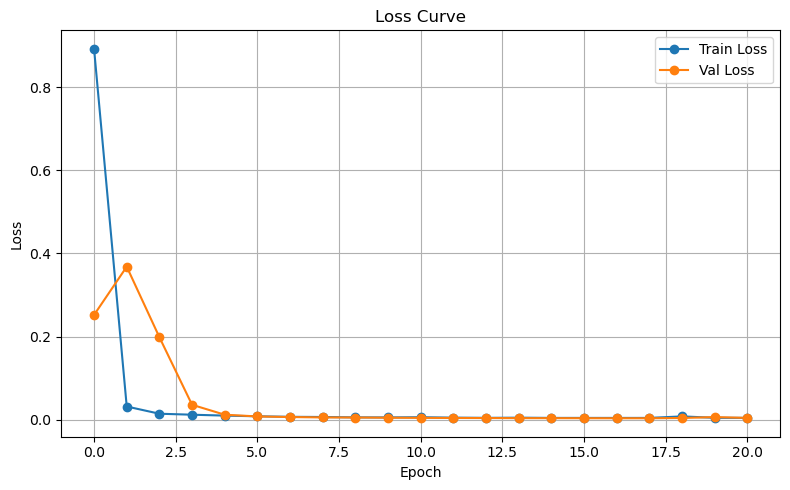

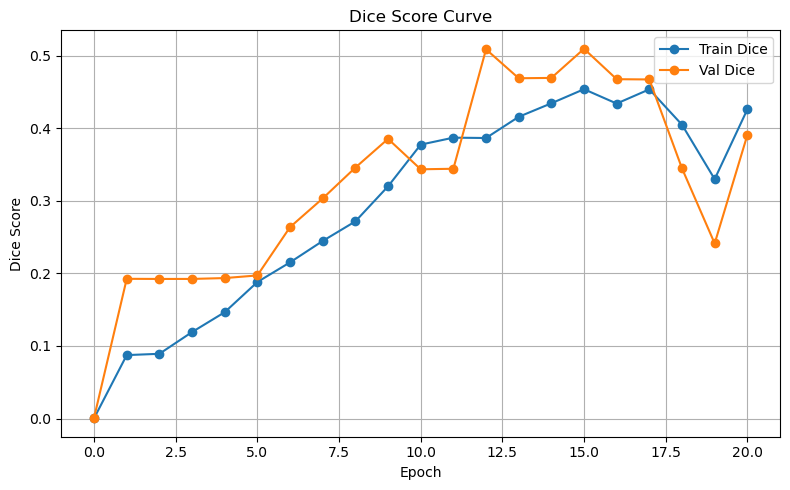

In [21]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(hist["train_loss"], label="Train Loss", marker='o')
plt.plot(hist["val_loss"], label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Dice Score
plt.figure(figsize=(8, 5))
plt.plot(hist["train_dice"], label="Train Dice", marker='o')
plt.plot(hist["val_dice"], label="Val Dice", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Dice Score Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Evaluate the Trained model on testing dataset

In [22]:
# Set the model to evaluation mode
model.eval()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Disable gradient computation for inference
with torch.no_grad():
    # Iterate over the test dataset in batches
    for batch_idx, (x_test, y_test) in enumerate(test_loader_brats):
        # Move the input and target tensors to the selected device
        x_test = x_test.to(device)
        y_test = y_test.to(device).float()

        # Get the model predictions and apply sigmoid to convert logits to probabilities
        preds = torch.sigmoid(model(x_test)).cpu().numpy()  # Convert predictions to NumPy array
        y_test = y_test.cpu().numpy()  # Convert ground truth to NumPy array
        x_test = x_test.cpu().numpy()  # Convert input volume to NumPy array

        # Extract the first sample in the batch for visualization or analysis
        input_vol = x_test[0]  # Input volume (e.g., MRI scan)
        pred_mask = preds[0][0]  # Predicted tumor mask
        true_mask = y_test[0][0]  # Ground truth tumor mask

        # Check for tumor presence in the ground truth mask
        tumor_presence = np.atleast_1d(true_mask.sum(axis=(0, 1)) > 0)  # Identify slices with tumors
        tumor_slices = np.where(tumor_presence)[0]  # Get the indices of slices with tumors

        # If tumor slices are found, print the batch index and the first few slice indices
        if len(tumor_slices) > 0:
            print(f"Found tumor in batch {batch_idx}, slices: {tumor_slices[:5]}")
            break  # Exit the loop after finding a tumor
    else:
        # If no tumor is found in any batch, print a message
        print("No tumor found in any test batches.")

Found tumor in batch 1, slices: [0]


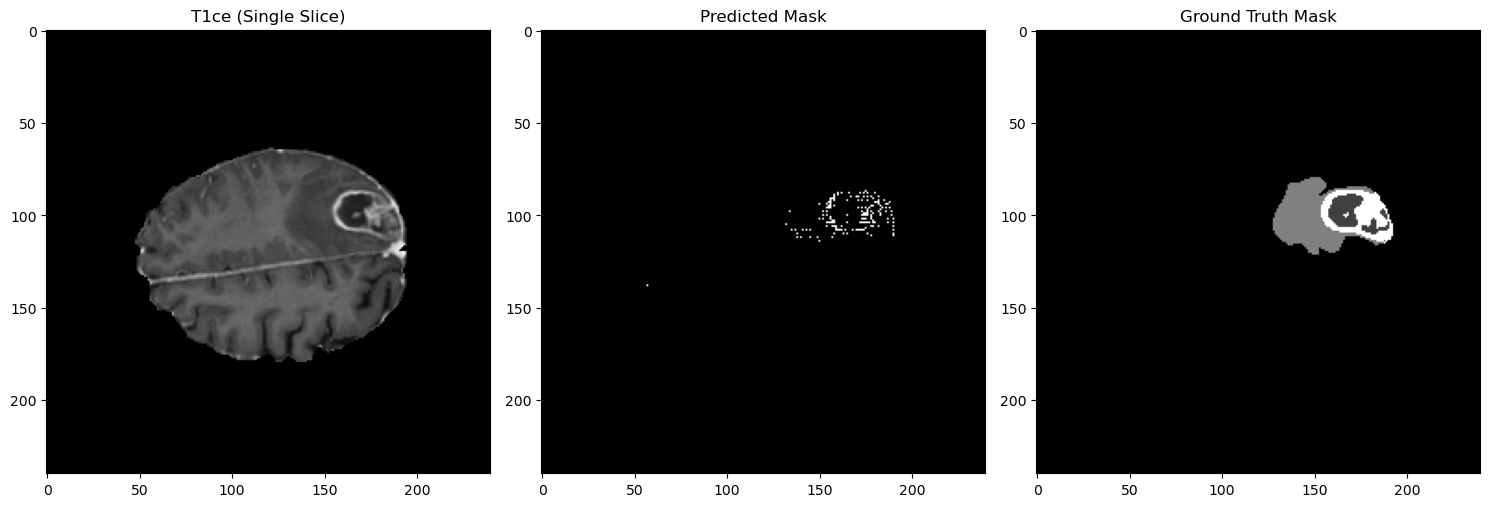

In [23]:
plt.figure(figsize=(15, 5))

# Input T1ce image (channel 1)
plt.subplot(1, 3, 1)
plt.imshow(input_vol[1], cmap="gray")  # Already 2D
plt.title("T1ce (Single Slice)")

# Predicted mask
plt.subplot(1, 3, 2)
plt.imshow(pred_mask > 0.3, cmap="gray")
plt.title("Predicted Mask")

# Ground truth
plt.subplot(1, 3, 3)
plt.imshow(true_mask, cmap="gray")
plt.title("Ground Truth Mask")

plt.tight_layout()
plt.show()


In [24]:
def compute_metrics(preds, targets, threshold=0.5):
    """
    Computes evaluation metrics (Dice Score, IoU, Precision, Recall) for predictions and targets.

    Args:
        preds (Tensor): Raw logits output from the model (no sigmoid applied).
        targets (Tensor): Ground truth binary mask (0 or 1).
        threshold (float): Threshold for converting sigmoid probabilities to a binary mask.

    Returns:
        tuple: Mean Dice Score, IoU, Precision, and Recall across the batch.
    """
    # Apply sigmoid to raw logits to get probabilities
    preds = torch.sigmoid(preds)
    
    # Convert probabilities to binary predictions using the threshold
    preds = (preds > threshold).float()

    # Compute True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = (preds * targets).sum(dim=(1, 2, 3))  # True Positives: overlap between predictions and targets
    FP = ((preds == 1) & (targets == 0)).sum(dim=(1, 2, 3))  # False Positives: predicted 1 but target is 0
    FN = ((preds == 0) & (targets == 1)).sum(dim=(1, 2, 3))  # False Negatives: predicted 0 but target is 1

    # Compute the union of predictions and targets for Dice Score
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))

    # Compute metrics with smoothing to avoid division by zero
    dice = (2 * TP + 1e-7) / (union + 1e-7)  # Dice Score
    iou = (TP + 1e-7) / (TP + FP + FN + 1e-7)  # Intersection over Union (IoU)
    precision = (TP + 1e-7) / (TP + FP + 1e-7)  # Precision
    recall = (TP + 1e-7) / (TP + FN + 1e-7)  # Recall

    # Return the mean of each metric across the batch
    return dice.mean().item(), iou.mean().item(), precision.mean().item(), recall.mean().item()


# Run evaluation on the full test set
model.eval()  # Set the model to evaluation mode (disables dropout and batch normalization updates)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU

# Initialize lists to store metrics for all batches
all_dice, all_iou, all_precision, all_recall = [], [], [], []

# Disable gradient computation for inference
with torch.no_grad():
    # Iterate over the test dataset in batches
    for x_test, y_test in test_loader_brats:
        # Move the input and target tensors to the selected device
        x_test = x_test.to(device)
        y_test = y_test.to(device).float()

        # Normalize the target mask if values are greater than 1 (e.g., 0-255 range)
        if y_test.max() > 1:
            y_test = y_test / 255.0

        # Get the model predictions (raw logits)
        preds = model(x_test)

        # Compute metrics for the current batch
        dice, iou, precision, recall = compute_metrics(preds, y_test)

        # Append the metrics to their respective lists
        all_dice.append(dice)
        all_iou.append(iou)
        all_precision.append(precision)
        all_recall.append(recall)

# Print the final average scores across all batches
print("Evaluation on Test Set:")
print(f"Dice Score:     {np.mean(all_dice):.4f}")  # Average Dice Score
print(f"IoU:            {np.mean(all_iou):.4f}")  # Average IoU
print(f"Precision:      {np.mean(all_precision):.4f}")  # Average Precision
print(f"Recall:         {np.mean(all_recall):.4f}")  # Average Recall

Evaluation on Test Set:
Dice Score:     0.4802
IoU:            0.8258
Precision:      0.8258
Recall:         1.0000


##### Loading and preprocessing IDC-IDRI Dataset

In [25]:
import os

# List all files and match the ZIP file exactly
files = os.listdir("Data")
zip_filename = [f for f in files if f.lower().endswith(".zip") and "lidc" in f.lower()]
print("Found zip file(s):", zip_filename)


Found zip file(s): ['LIDC-IDRI.zip']


In [26]:
'''' import zipfile

zip_path = os.path.join("Data", zip_filename[0])
extract_path = "Data/LIDC-IDRI"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path) '''


'\' import zipfile\n\nzip_path = os.path.join("Data", zip_filename[0])\nextract_path = "Data/LIDC-IDRI"\n\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\nprint("Extracted to:", extract_path) '

torch.Size([4, 128, 128]) torch.Size([1, 128, 128])


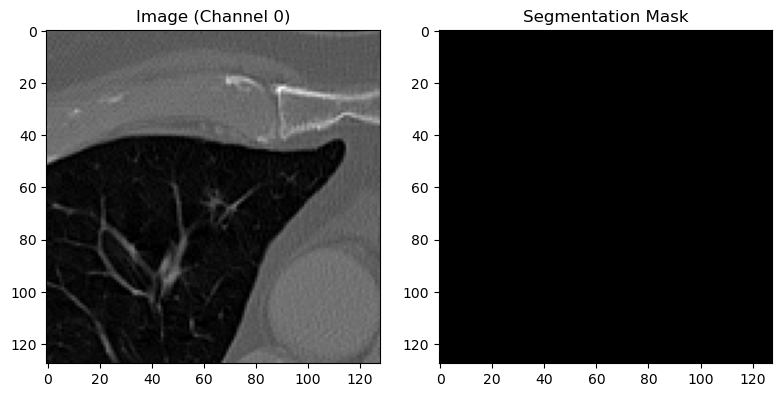

In [27]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

class LIDCIDRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing patient folders.
            transform (albumentations.Compose): Albumentations transform applied to both image and mask.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # List of (image_path, [mask_paths])

        for patient_id in os.listdir(self.root_dir):
            patient_dir = os.path.join(self.root_dir, patient_id)
            for nodule_id in os.listdir(patient_dir):
                nodule_dir = os.path.join(patient_dir, nodule_id)
                image_dir = os.path.join(nodule_dir, 'images')
                mask_dirs = [os.path.join(nodule_dir, f'mask-{i}') for i in range(4)]

                image_files = sorted(os.listdir(image_dir))
                for img_file in image_files:
                    img_path = os.path.join(image_dir, img_file)
                    mask_paths = [os.path.join(mdir, img_file) for mdir in mask_dirs]
                    self.samples.append((img_path, mask_paths))

    def __len__(self):
        return len(self.samples)

    def load_image(self, path):
        return Image.open(path).convert('L')

    def load_and_combine_masks(self, mask_paths):
        masks = []
        for mask_path in mask_paths:
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
                mask = np.array(mask) > 0
                masks.append(mask.astype(np.uint8))
            else:
                # All-zero mask fallback
                if masks:
                    masks.append(np.zeros_like(masks[0]))
                else:
                    masks.append(np.zeros((512, 512), dtype=np.uint8))  # or infer size from dataset
        combined = np.mean(masks, axis=0)
        combined = (combined >= 0.5).astype(np.uint8)
        return combined * 255  # to match image pixel intensity

    def __getitem__(self, idx):
        img_path, mask_paths = self.samples[idx]

        image = self.load_image(img_path)
        mask = self.load_and_combine_masks(mask_paths)

        image_np = np.array(image)  # [H, W]
        mask_np = np.array(mask)    # [H, W]

        # Stack grayscale image 4 times to match BraTS input format
        image_np = np.stack([image_np]*4, axis=-1)  # [H, W, 4]
        mask_np = mask_np.astype(np.uint8)          # [H, W]

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented["image"]                  # [4, H, W]
            mask = augmented["mask"].unsqueeze(0)       # [1, H, W]
        else:
            image = torch.from_numpy(image_np.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask_np).unsqueeze(0).float() / 255.0

        return image, mask



# Define only once, outside your dataset class
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

val_transform = Compose([
    Resize(128, 128),
    Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

# Load the dataset
dataset_path = "Data/LIDC-IDRI/LIDC-IDRI-slices"
dataset = LIDCIDRIDataset(dataset_path, transform=val_transform)

# Preview a sample
image, mask = dataset[50]
print(image.shape, mask.shape)  # Should be [4, 128, 128], [1, 128, 128]

# Sanity check: Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image[0].cpu(), cmap='gray')
plt.title("Image (Channel 0)")

plt.subplot(1, 2, 2)
plt.imshow(mask[0].cpu(), cmap='gray')
plt.title("Segmentation Mask")

plt.tight_layout()
plt.show()



### Data loader for training (LIDC)

In [29]:
from torch.utils.data import random_split, DataLoader

total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

#Inject transforms (Albumentations)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader_lidc = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader_lidc   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader_lidc  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train/Val/Test datasets created:")
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


Train/Val/Test datasets created:
Train size: 10883
Val size: 2332
Test size: 2333


#### Unified Training loop

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dice + BCE Combined Loss
class BCEDiceLoss(nn.Module):
    """
    A custom loss function that combines Binary Cross-Entropy (BCE) loss 
    and Dice loss for segmentation tasks. This helps optimize both pixel-wise 
    accuracy and overlap between predicted and ground truth masks.
    """
    def __init__(self, bce_weight=0.5, smooth=1e-5):
        """
        Initializes the BCEDiceLoss class.

        Args:
            bce_weight (float): Weight for BCE loss in the combined loss.
            smooth (float): Smoothing factor to avoid division by zero in Dice loss.
        """
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        Computes the combined BCE and Dice loss.

        Args:
            inputs (torch.Tensor): Predicted logits from the model.
            targets (torch.Tensor): Ground truth binary masks.

        Returns:
            torch.Tensor: Combined BCE and Dice loss.
        """
        bce_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)  # Convert logits to probabilities
        intersection = (probs * targets).sum(dim=(1, 2, 3))
        dice = (2 * intersection + self.smooth) / (probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + self.smooth)
        dice_loss = 1 - dice.mean()
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss


# Unified Trainer
def unified_train_model(model, loaders, val_loaders, num_epochs=10, lr=1e-4):
    """
    Trains a segmentation model on multiple datasets with a unified training loop.

    Args:
        model (torch.nn.Module): The segmentation model to train.
        loaders (tuple): Tuple containing training data loaders for different datasets.
        val_loaders (tuple): Tuple containing validation data loaders for different datasets.
        num_epochs (int): Number of epochs to train the model.
        lr (float): Learning rate for the optimizer.

    Returns:
        dict: A dictionary containing training and validation loss and Dice scores.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function, optimizer, and learning rate scheduler
    criterion = BCEDiceLoss(bce_weight=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Early stopping and performance tracking
    best_val_dice = 0
    epochs_no_improve = 0
    early_stop_patience = 5

    # History dictionary to store metrics
    hist = {
        "train_loss": [], "train_dice": [],
        "val_loss_brats": [], "val_dice_brats": [],
        "val_loss_lidc": [], "val_dice_lidc": []
    }

    # Unpack data loaders
    brats_loader, lidc_loader = loaders
    val_brats_loader, val_lidc_loader = val_loaders

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_dice = 0.0, 0.0
        total_batches = len(brats_loader) + len(lidc_loader)
        pbar = tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}")

        # Training loop for both datasets
        for loader in [brats_loader, lidc_loader]:
            for x, y in loader:
                x, y = x.to(device), y.to(device).float()
                if y.max() > 1:  # Ensure binary masks
                    y = (y > 0).float()

                optimizer.zero_grad()
                preds = model(x)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()

                dice = dice_score(preds, y)  # Compute Dice score
                epoch_loss += loss.item()
                epoch_dice += dice
                pbar.update(1)
                pbar.set_postfix(loss=loss.item(), dice=dice)

        pbar.close()

        # Average training loss and Dice score
        epoch_loss /= total_batches
        epoch_dice /= total_batches

        # Validation - BraTS dataset
        model.eval()
        val_loss_brats, val_dice_brats = 0.0, 0.0
        with torch.no_grad():
            for x_val, y_val in val_brats_loader:
                x_val, y_val = x_val.to(device), y_val.to(device).float()
                if y_val.max() > 1:
                    y_val = (y_val > 0).float()

                preds_val = model(x_val)
                val_loss_brats += criterion(preds_val, y_val).item()
                val_dice_brats += dice_score(preds_val, y_val)

        val_loss_brats /= len(val_brats_loader)
        val_dice_brats /= len(val_brats_loader)

        # Validation - LIDC dataset
        val_loss_lidc, val_dice_lidc = 0.0, 0.0
        with torch.no_grad():
            for x_val, y_val in val_lidc_loader:
                x_val, y_val = x_val.to(device), y_val.to(device).float()
                if y_val.max() > 1:
                    y_val = (y_val > 0).float()

                preds_val = model(x_val)
                val_loss_lidc += criterion(preds_val, y_val).item()
                val_dice_lidc += dice_score(preds_val, y_val)

        val_loss_lidc /= len(val_lidc_loader)
        val_dice_lidc /= len(val_lidc_loader)

        # Optional visualization of predictions every 5 epochs
        if epoch % 5 == 0:
            sample_pred = torch.sigmoid(preds_val[0][0]).detach().cpu().numpy()
            sample_mask = y_val[0][0].cpu().numpy()

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(sample_pred > 0.5, cmap='gray')
            plt.title("Prediction")
            plt.subplot(1, 2, 2)
            plt.imshow(sample_mask, cmap='gray')
            plt.title("Ground Truth")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Train Dice: {epoch_dice:.4f} | "
              f"Val Loss (BraTS): {val_loss_brats:.4f}, Val Dice (BraTS): {val_dice_brats:.4f} | "
              f"Val Loss (LIDC): {val_loss_lidc:.4f}, Val Dice (LIDC): {val_dice_lidc:.4f}")

        # Update learning rate scheduler
        scheduler.step(val_loss_brats)

        # Log metrics
        hist["train_loss"].append(epoch_loss)
        hist["train_dice"].append(epoch_dice)
        hist["val_loss_brats"].append(val_loss_brats)
        hist["val_dice_brats"].append(val_dice_brats)
        hist["val_loss_lidc"].append(val_loss_lidc)
        hist["val_dice_lidc"].append(val_dice_lidc)

        # Early stopping based on validation Dice score
        val_dice_avg = (val_dice_brats + val_dice_lidc) / 2
        if val_dice_avg > best_val_dice:
            best_val_dice = val_dice_avg
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print("Unified Training Completed.")
    return hist

Epoch 1/30:   0%|          | 0/1374 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1374/1374 [03:48<00:00,  6.03it/s, dice=0.591, loss=0.275] 


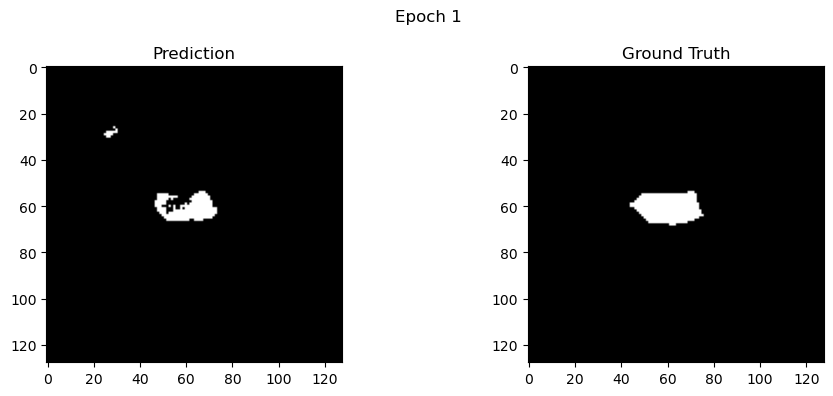

Epoch 1/30 | Train Loss: 0.3916, Train Dice: 0.3230 | Val Loss (BraTS): 0.5483, Val Dice (BraTS): 0.1927 | Val Loss (LIDC): 0.3403, Val Dice (LIDC): 0.4123


Epoch 2/30: 100%|██████████| 1374/1374 [02:01<00:00, 11.28it/s, dice=0.491, loss=0.261] 


Epoch 2/30 | Train Loss: 0.3274, Train Dice: 0.4322 | Val Loss (BraTS): 0.4762, Val Dice (BraTS): 0.3120 | Val Loss (LIDC): 0.3193, Val Dice (LIDC): 0.4646


Epoch 3/30: 100%|██████████| 1374/1374 [01:58<00:00, 11.64it/s, dice=0.922, loss=0.225]


Epoch 3/30 | Train Loss: 0.3095, Train Dice: 0.4657 | Val Loss (BraTS): 0.5115, Val Dice (BraTS): 0.2416 | Val Loss (LIDC): 0.3117, Val Dice (LIDC): 0.4858


Epoch 4/30: 100%|██████████| 1374/1374 [01:58<00:00, 11.58it/s, dice=0.646, loss=0.193]


Epoch 4/30 | Train Loss: 0.2970, Train Dice: 0.4848 | Val Loss (BraTS): 0.4825, Val Dice (BraTS): 0.3012 | Val Loss (LIDC): 0.3030, Val Dice (LIDC): 0.4677


Epoch 5/30: 100%|██████████| 1374/1374 [01:59<00:00, 11.51it/s, dice=0.338, loss=0.34]  


Epoch 5/30 | Train Loss: 0.2898, Train Dice: 0.5017 | Val Loss (BraTS): 0.5487, Val Dice (BraTS): 0.1985 | Val Loss (LIDC): 0.3013, Val Dice (LIDC): 0.4819


Epoch 6/30: 100%|██████████| 1374/1374 [01:57<00:00, 11.72it/s, dice=0.467, loss=0.279] 


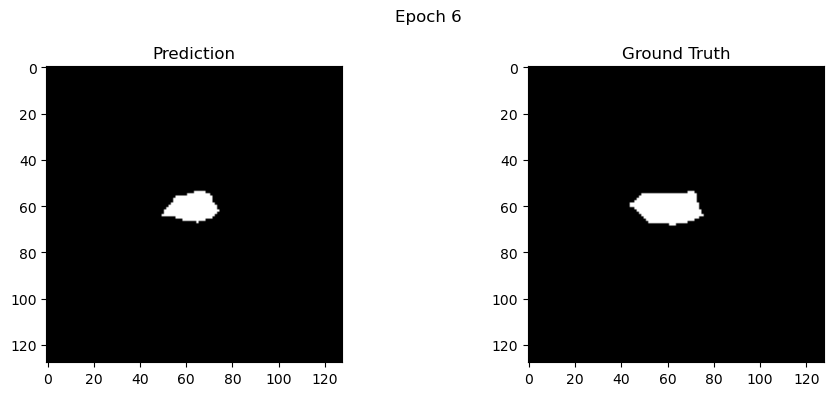

Epoch 6/30 | Train Loss: 0.2858, Train Dice: 0.5055 | Val Loss (BraTS): 0.5670, Val Dice (BraTS): 0.2334 | Val Loss (LIDC): 0.2903, Val Dice (LIDC): 0.5133


Epoch 7/30: 100%|██████████| 1374/1374 [01:58<00:00, 11.64it/s, dice=0.95, loss=0.197] 


Epoch 7/30 | Train Loss: 0.2707, Train Dice: 0.5385 | Val Loss (BraTS): 0.5614, Val Dice (BraTS): 0.1924 | Val Loss (LIDC): 0.2877, Val Dice (LIDC): 0.4917
Early stopping triggered at epoch 7
Unified Training Completed.


In [32]:
modelV2 = UNet2D(in_channels=4, out_channels=1)
hist = unified_train_model(
    modelV2,
    loaders=(train_loader_brats, train_loader_lidc),
    val_loaders=(val_loader_brats, val_loader_lidc),
    num_epochs=30,
    lr=1e-4
)


### Evaluation accros datasets

In [40]:
def evaluate(model, loader):
    """
    Evaluates the performance of a segmentation model on a given dataset loader.

    Args:
        model (torch.nn.Module): The trained segmentation model to evaluate.
        loader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate on.

    Prints:
        Dice score, IoU, Precision, and Recall averaged over the dataset.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dices, ious, precisions, recalls = [], [], [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device).float()

            if y.max() > 1:
                y = (y > 0).float()

            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5)

            # Convert y to binary
            y_bin = (y > 0.5)

            # Flatten for metric computation
            preds_flat = preds.view(-1)
            targets_flat = y_bin.view(-1)

            TP = (preds_flat & targets_flat).sum().item()
            FP = (preds_flat & ~targets_flat).sum().item()
            FN = (~preds_flat & targets_flat).sum().item()

            dice = (2 * TP + 1e-7) / (preds_flat.sum().item() + targets_flat.sum().item() + 1e-7)
            iou = (TP + 1e-7) / (TP + FP + FN + 1e-7)
            precision = (TP + 1e-7) / (TP + FP + 1e-7)
            recall = (TP + 1e-7) / (TP + FN + 1e-7)

            dices.append(dice)
            ious.append(iou)
            precisions.append(precision)
            recalls.append(recall)

    print(f"Dice: {np.mean(dices):.4f}")
    print(f"IoU: {np.mean(ious):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")



# Evaluate the model on the BraTS dataset
print("BraTS Evaluation:")
evaluate(model, test_loader_brats)

# Evaluate the model on the LIDC-IDRI dataset
print("\nLIDC-IDRI Evaluation:")
evaluate(modelV2, test_loader_lidc)

BraTS Evaluation:
Dice: 0.0321
IoU: 0.0164
Precision: 0.9862
Recall: 0.0164

LIDC-IDRI Evaluation:
Dice: 0.6383
IoU: 0.4891
Precision: 0.5714
Recall: 0.7867


### Visualize prediction

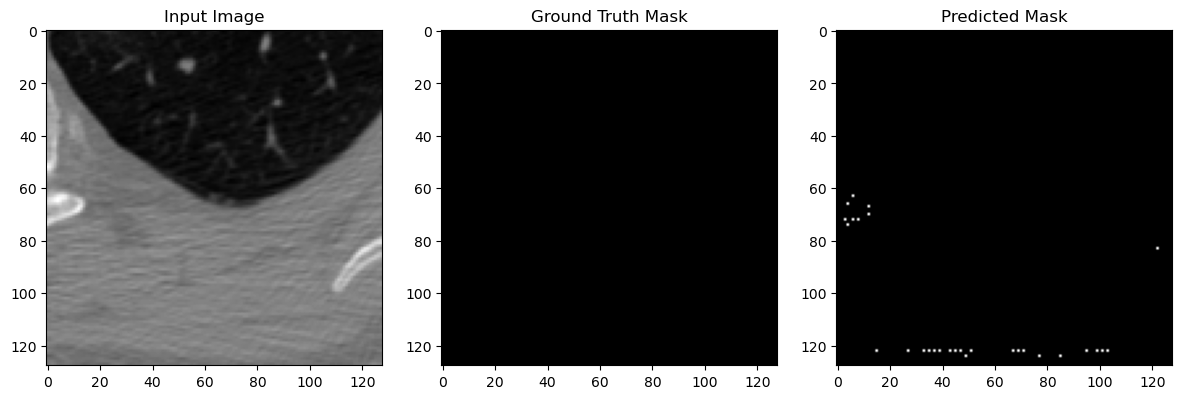

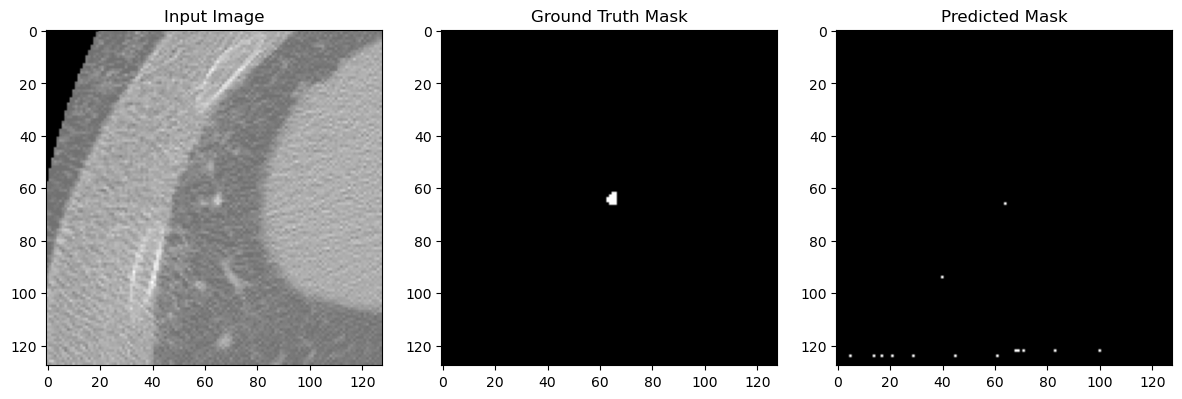

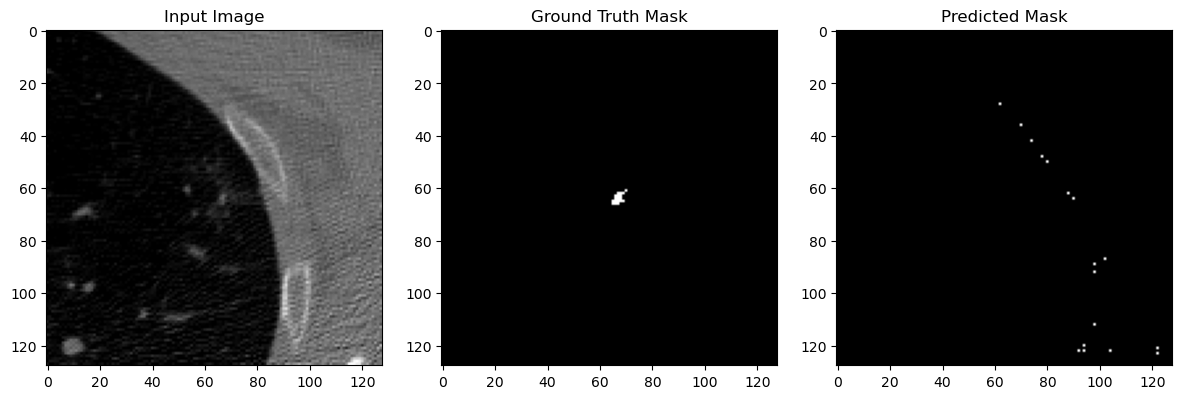

In [42]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_samples=3):
    """
    Visualizes predictions of a segmentation model alongside input images 
    and ground truth masks.

    Args:
        model (torch.nn.Module): The trained segmentation model to visualize.
        loader (torch.utils.data.DataLoader): DataLoader for the dataset to visualize.
        num_samples (int): Number of samples to visualize. Defaults to 3.

    Displays:
        A set of plots for each sample showing the input image, ground truth mask, 
        and predicted mask.
    """
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    samples_shown = 0  # Counter to track the number of samples visualized

    with torch.no_grad():  # Disable gradient computation for visualization
        for x, y in loader:
            # Move input images to the appropriate device and ground truth masks to CPU
            x, y = x.to(device), y.cpu().numpy()

            # Get model predictions and apply sigmoid activation and thresholding
            preds = torch.sigmoid(model(x)).cpu().numpy() > 0.5

            # Iterate through the batch to visualize each sample
            for i in range(x.size(0)):
                plt.figure(figsize=(12, 4))

                # Plot the input image
                plt.subplot(1, 3, 1)
                plt.imshow(x[i, 0].cpu(), cmap='gray')
                plt.title("Input Image")

                # Plot the ground truth mask
                plt.subplot(1, 3, 2)
                plt.imshow(y[i, 0], cmap='gray')
                plt.title("Ground Truth Mask")

                # Plot the predicted mask
                plt.subplot(1, 3, 3)
                plt.imshow(preds[i, 0], cmap='gray')
                plt.title("Predicted Mask")

                # Adjust layout and display the plots
                plt.tight_layout()
                plt.show()

                # Increment the counter and stop if the desired number of samples is shown
                samples_shown += 1
                if samples_shown >= num_samples:
                    return

# Example call:
# Visualize predictions on the BraTS test dataset
visualize_predictions(model, test_loader_lidc)

### Plot Training curves

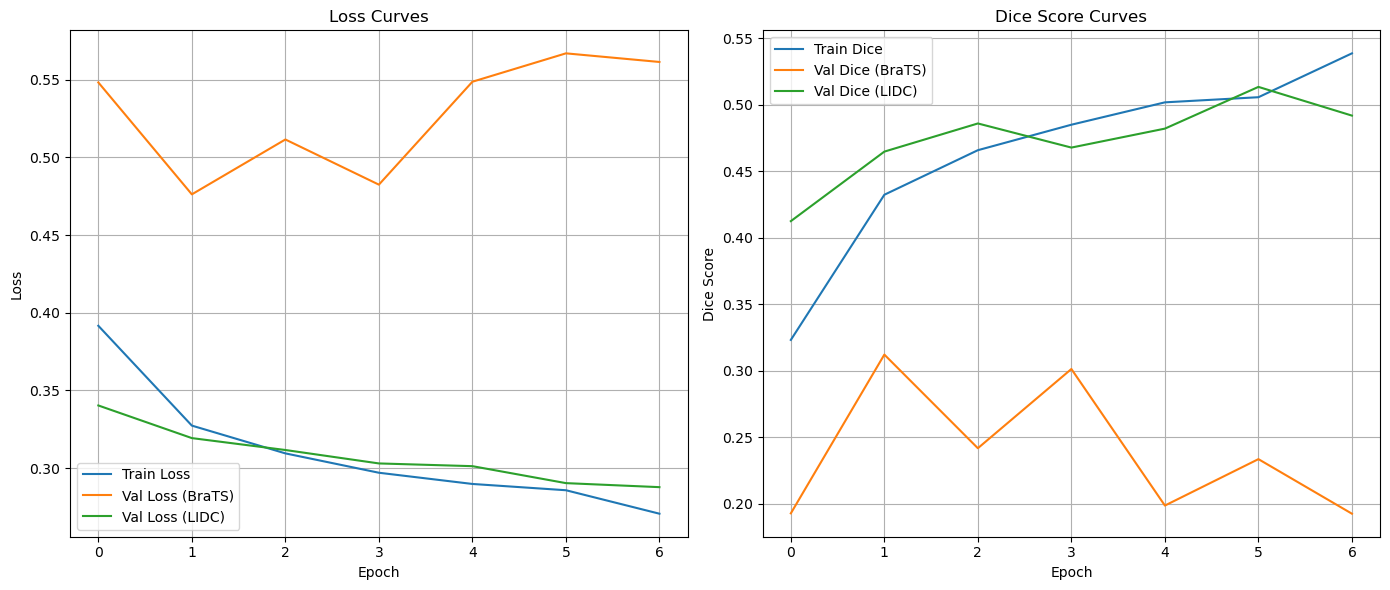

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss_brats"], label="Val Loss (BraTS)")
plt.plot(hist["val_loss_lidc"], label="Val Loss (LIDC)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

# Dice Score Curves
plt.subplot(1, 2, 2)
plt.plot(hist["train_dice"], label="Train Dice")
plt.plot(hist["val_dice_brats"], label="Val Dice (BraTS)")
plt.plot(hist["val_dice_lidc"], label="Val Dice (LIDC)")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Dice Score Curves")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##### Building a model architecture

In [36]:
from torchsummary import summary

model_T = UNet2D(in_channels=4, out_channels=1).to("cuda")  # move model to GPU
summary(model_T, input_size=(4, 128, 128))  # input shape should match your dataset


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,304
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        LeakyReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
        LeakyReLU-14          [-1, 128,

In [37]:
# Print model summary
print(model_T)

UNet2D(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [38]:
from torchviz import make_dot
import torch

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_T = model_T.to(device)

# Create a sample input on the same device
x = torch.randn(1, 4, 128, 128, device=device).requires_grad_(True)

# Forward pass
y = model_T(x)

# Visualize computation graph
make_dot(y, params=dict(list(model_T.named_parameters()))).render("unet_arch", format="png")


'unet_arch.png'